# DIGIT RECOGNIZER

This is my solution to the [digit recognizer](https://www.kaggle.com/c/digit-recognizer) competition using ResNet34.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import csv
from PIL import Image

In [3]:
bs = 64

In [4]:
mkdir '/kaggle/working/train'

In [5]:
mkdir '/kaggle/working/test'

In [6]:
csv_path = Path('../input/digit-recognizer')
csv_path.ls()

[PosixPath('../input/digit-recognizer/test.csv'),
 PosixPath('../input/digit-recognizer/sample_submission.csv'),
 PosixPath('../input/digit-recognizer/train.csv')]

In [7]:
img_path = Path('/kaggle/working/')
img_path.ls()

[PosixPath('/kaggle/working/.ipynb_checkpoints'),
 PosixPath('/kaggle/working/__notebook_source__.ipynb'),
 PosixPath('/kaggle/working/train'),
 PosixPath('/kaggle/working/test')]

In [8]:
def convert_pixels_to_image(pixels):
    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape((28, 28))
    image = Image.fromarray(pixels)
    
    return image

In [9]:
counter = dict()

with open(csv_path/'train.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)

    for row in csv_reader:
        pixels = row[1:]
        image = convert_pixels_to_image(pixels)

        label = row[0]

        if label not in counter:
            counter[label] = 0
        counter[label] += 1

        filename = '{}_{}.jpg'.format(label, counter[label])
        image.save(img_path/'train'/filename)

In [10]:
counter = 0

with open(csv_path/'test.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)

    for row in csv_reader:
        pixels = row
        image = convert_pixels_to_image(pixels)
        counter += 1

        filename = '{}.jpg'.format(counter)
        image.save(img_path/'test'/filename)

In [11]:
fnames = get_image_files(img_path/'train')

In [12]:
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [13]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(img_path, fnames, pat, ds_tfms=get_transforms(), size=14, bs=bs, num_workers=0
                                  ).normalize(imagenet_stats)

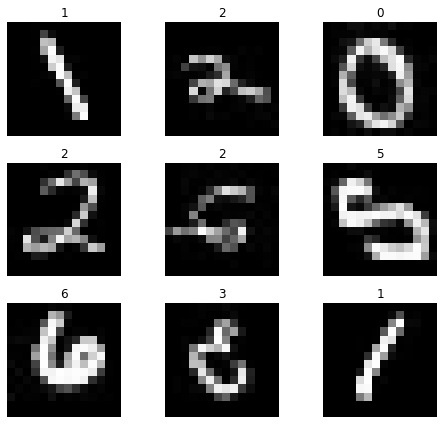

In [14]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 10, 33600, 8400)

In [16]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [17]:
lr = 0.01

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.470542,0.987243,0.321429,01:29
1,0.663213,0.409619,0.137024,01:27
2,0.404838,0.233206,0.074405,01:26
3,0.327396,0.170580,0.054643,01:26
4,0.296862,0.171786,0.053214,01:25


In [19]:
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


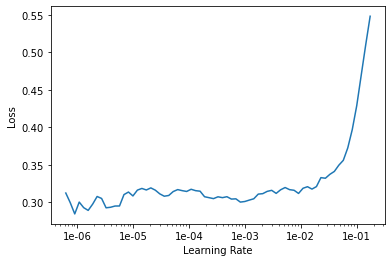

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.260371,0.155595,0.050476,01:26
1,0.271503,0.149785,0.045952,01:26
2,0.285023,0.146984,0.046905,01:24
3,0.239786,0.139535,0.042738,01:24
4,0.231337,0.134830,0.043571,01:25


In [22]:
learn.save('stage-2')

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.262986,0.138665,0.040952,01:31
1,0.178070,0.097354,0.029643,01:30
2,0.137759,0.086947,0.028929,01:30
3,0.101625,0.058850,0.017857,01:29
4,0.090290,0.051516,0.014881,01:30


In [25]:
learn.save('stage-3')

In [26]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(img_path, fnames, pat, ds_tfms=get_transforms(), size=28, bs=bs, num_workers=0
                                  ).normalize(imagenet_stats)

In [27]:
learn.data = data

In [28]:
learn.freeze()

In [29]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.340294,0.198048,0.063214,01:27
1,0.179769,0.098234,0.030000,01:26
2,0.128004,0.077820,0.022976,01:27
3,0.105428,0.056873,0.018810,01:25
4,0.108647,0.053424,0.018214,01:26


In [30]:
learn.save('stage-4')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


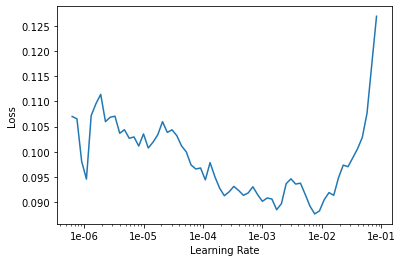

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.098401,0.054429,0.017857,01:25
1,0.080197,0.059462,0.018214,01:25
2,0.081012,0.049451,0.016071,01:25
3,0.070444,0.048254,0.016905,01:24
4,0.080344,0.046463,0.014643,01:25


In [33]:
learn.save('stage-5')

In [34]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.115748,0.067290,0.020357,01:29
1,0.095392,2.870324,0.030357,01:27
2,0.069216,0.100620,0.014524,01:29
3,0.046966,0.153066,0.011786,01:30
4,0.039275,0.116554,0.009524,01:30


In [36]:
learn.save('stage-6')

In [44]:
learn.export()

In [46]:
learn = load_learner(img_path)

In [47]:
img = open_image(img_path/'test'/'1.jpg')
img

In [48]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

2


In [53]:
test = os.listdir(img_path/'test')
test.sort(key=lambda f: int(re.sub('\D', '', f)))

with open(img_path/'submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'Label'])
    
    for image_file in test:
        image = os.path.join(img_path/'test', image_file) 
        image_id = Path(image).stem

        img = open_image(image)
        pred_class,pred_idx,outputs = learn.predict(img)
        label = str(pred_class)
        
        writer.writerow([image_id, label])